In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# df = pd.read_csv('labeled_data.csv')
# read_csv may be different depending on your folder structure
df = pd.read_csv('/content/drive/MyDrive/ML Final Project/labeled_data.csv')

Clean up but don't remove stop words




In [ ]:
import re 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))   

char_list = ['RT', '@']
df['tweet clean'] = df['tweet']

i = 0

for tweet in df['tweet']:
  tweet.replace('.', ' ')
  tweet.replace(',', ' ')
  temp = [ele.strip(string.punctuation) for ele in tweet.split(' ') if all(ch not in ele for ch in char_list)]
  #temp = [w for w in temp if not w.lower() in stop_words]  
  temp = [t for t in temp if "&#" not in t and ';' not in t]
  temp = re.sub(r"http\S+", "", ' '.join(temp))
  df['tweet clean'][i] = temp
  i = i +1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
!pip install transformers
!pip install --upgrade tensorflow

import torch
from transformers import BertTokenizer, BertModel
#import logging
import matplotlib.pyplot as plt
% matplotlib inline

# BERT features
def get_bert_features():
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  # Load pre-trained model (weights)
  model = BertModel.from_pretrained('bert-base-uncased',
                                    output_hidden_states = True, # Whether the model returns all hidden-states.
                                    )
  model.eval()
  df['bert'] = df['tweet clean']

  for i, text in enumerate(df["tweet clean"]):
   
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)

    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)
    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    # Mark each of the tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)

      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states = outputs[2]

    token_vecs = hidden_states[-2][0]

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    #print(len(sentence_embedding))

    df["bert"][i] = sentence_embedding
  
get_bert_features()

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet clean,bert
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,As a woman you shouldn't complain about clean...,"[tensor(0.3538), tensor(0.3560), tensor(-0.261..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold...tyga dwn bad for cuffin dat h...,"[tensor(-0.6817), tensor(0.3043), tensor(0.350..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Dawg You ever fuck a bitch and she start to c...,"[tensor(0.1278), tensor(0.7942), tensor(0.3382..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny,"[tensor(0.2010), tensor(-0.0991), tensor(0.020..."
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,The shit you hear about me might be true or i...,"[tensor(0.5212), tensor(0.0923), tensor(0.1123..."
...,...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you's a muthaf***in lie right His TL is trash ...,"[tensor(0.5353), tensor(0.6767), tensor(0.5115..."
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",you've gone and broke the wrong heart baby and...,"[tensor(0.2227), tensor(-0.0919), tensor(-0.18..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like I aint fu...,"[tensor(-0.1543), tensor(0.5007), tensor(0.510..."
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies,"[tensor(0.2996), tensor(0.5114), tensor(0.1901..."


In [ ]:
for i in range(10):
  print(len(df['bert'][i]))


768
768
768
768
768
768
768
768
768
768


In [ ]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

def constructFeatureMatrix(option):
  y = df['class']

  # to address imbalanced data - https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
  rus = RandomUnderSampler(sampling_strategy='majority')

  X = np.zeros((len(df), 768))
  for i in range(len(df)):
    #print(i, len(df['bert'][i]))
    X[i] = df['bert'][i]

  X_new, y_new = rus.fit_resample(X, y)
  return X_new, y_new


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
def calculateKFoldAccuracy(features, labels):
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    model1 = LogisticRegression()
    model2 = LinearSVC()
    model3 = SVC(kernel='rbf')
    # check if X has all of the features 
    lr_acc = cross_val_score(model1, features, labels, cv = kf)
    svm_acc = cross_val_score(model2, features, labels, cv = kf)
    rbf_acc = cross_val_score(model3, features, labels, cv = kf)

    print("Logistic Regression Average Accuracy: " + str(lr_acc.mean()))
    print("SVM Average Accuracy: " + str(svm_acc.mean()))
    print("RBF Average Accuract: " + str(rbf_acc.mean()))

In [ ]:
# Hyperparameter Sweep
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

def bestHyperparameters(best_params_list, model_type):
  max_iterations = []
  regularizers = []
  for param in best_params_list:
    max_iterations.append(param['max_iter'])
    if (model_type=='rbf'):
      regularizers.append(param['C'])
    else:
      regularizers.append(param['penalty'])

  counter1 = Counter(max_iterations)
  max_count1 = max(counter1.values())
  mode1 = [k for k, v in counter1.items() if v == max_count1]

  counter2 = Counter(regularizers)
  max_count2 = max(counter2.values())
  mode2 = [k for k, v in counter2.items() if v == max_count2]

  return mode1[0], mode2[0]

def determineHyperparameters(features, labels, feature_type, model_type):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    if (model_type == 'logistic'):
      param_grid = {'max_iter': [200, 300, 400, 500], 'penalty': ['l2', 'None']}
      model = LogisticRegression()
    elif (model_type == 'linear_svc'):
      param_grid = {'max_iter': [500, 1000, 1500, 2000], 'penalty': ['l2', 'l1']}
      model = LinearSVC()
    elif (model_type == 'rbf'):
      param_grid = {'max_iter': [500, 1000, 1500, 2000], 'C': [0.5, 1.0]}
      model = SVC(kernel='rbf')

    best_params = []

    for train_indices, test_indices in kf.split(features):
        X_train=[features[ii] for ii in train_indices]
        X_valid=[features[ii] for ii in test_indices]
        y_train=[labels[ii] for ii in train_indices]
        y_valid=[labels[ii] for ii in test_indices]

        #I train the classifier
        trained=model.fit(X_train,y_train)

        hp_search = RandomizedSearchCV(estimator = trained, param_distributions=param_grid)
        hp_search.fit(X_valid, y_valid)
        best_params.append(hp_search.best_params_)

        break

    parameter1, parameter2 = bestHyperparameters(best_params, model_type)

    if (model_type == 'rbf'):
      return_dict = {'max_iter': parameter1, 'C': parameter2}
    else: 
      return_dict = {'max_iter': parameter1, 'penalty': parameter2}
    # Save these hyperparameters
    np.save(f'{model_type}_{feature_type}_params.npy', return_dict)

    return return_dict

In [ ]:
def perf_measure(y_actual, y_hat):
    # Used for calculating certain statistics
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    positives = 0
    negatives = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TP += 1
           positives += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
           positives += 1
        if (y_actual[i]==y_hat[i]==1) or (y_actual[i]==y_hat[i]==2):
           TN += 1
           negatives += 1
        if (y_hat[i]==1 or y_hat[i]==2) and y_actual[i]==0:
           FN += 1
           negatives += 1

    TP = TP / positives
    FP = FP / positives
    TN = TN / negatives
    FN = FN / negatives

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1 = (2*precision*recall) / (precision + recall)

    return np.array([TP, FP, TN, FN, recall, precision, f1])

In [ ]:
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns

# Will not be using cross_val_score here:
#I generate a KFold in order to make cross validation
def generateModel(features, labels, model_name, model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    hyperparameter_list = np.load(f'{model_type}_{model_name}_params.npy', allow_pickle=True).item()

    ac = 0
    cm = np.zeros((3,3))
    stats = np.zeros(7)

    #I start the cross validation
    for train_indices, test_indices in kf.split(features):
        X_train=[features[ii] for ii in train_indices]
        X_test=[features[ii] for ii in test_indices]
        y_train=[labels[ii] for ii in train_indices]
        y_test=[labels[ii] for ii in test_indices]

        if (model_type == 'logistic'):
          model = LogisticRegression(max_iter = 1500, penalty = 12)
        elif (model_type == 'linear_svc'):
          model = LinearSVC(max_iter = 1500)
        elif (model_type == 'rbf'):
          model = SVC(kernel='rbf', max_iter = hyperparameter_list['max_iter'], C = hyperparameter_list['C'])
        
        #I train the classifier
        trained=model.fit(X_train,y_train)

        # Save model
        pickle.dump(model, open(f"{model_type}_{model_name}.model", 'wb'))

        #I make the predictions
        predicted=model.predict(X_test)

        #I obtain the accuracy of this fold
        ac += accuracy_score(predicted,y_test)

        #I obtain the confusion matrix
        cm += confusion_matrix(y_test, predicted, normalize = 'true')

        #I should calculate the TP,TN, FP and FN 
        stats += perf_measure(y_test, predicted)

    ac = ac / 5
    cm = cm / 5
    stats = stats / 5

    print('Accuracy: ' + str(ac))
    print('Logistic Regression [TP, FP, TN, FN, recall, precision, f1: ')
    print(stats)
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

    return [ac, cm, stats]

In [ ]:
X_bert, y = constructFeatureMatrix('bert')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
determineHyperparameters(X_bert, y, 'bert', 'linear_svc')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the

{'max_iter': 1500, 'penalty': 'l2'}

In [ ]:
hyperparameter_list = np.load(f'linear_svc_bert_params.npy', allow_pickle=True).item()

hyperparameter_list

{'max_iter': 1500, 'penalty': 'l2'}

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.7899765793715972
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.63641478 0.36358522 0.88794433 0.11205567 0.85009975 0.63641478
 0.72776366]


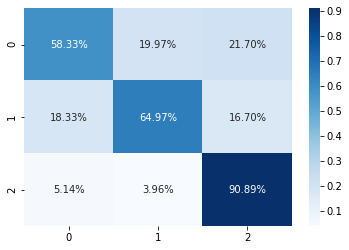

In [ ]:
list1 = generateModel(X_bert, y, 'bert', 'linear_svc')

In [ ]:
determineHyperparameters(X_bert, y, 'bert', 'rbf')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'max_iter': 500}

{'max_iter': 500, 'C': 1.0}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base

Accuracy: 0.7949605093733207
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.75316867 0.24683133 0.85491365 0.14508635 0.83850272 0.75316867
 0.7934281 ]


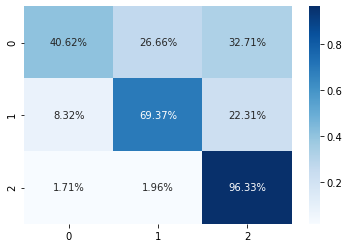

In [ ]:
hyperparameter_list = np.load(f'rbf_bert_params.npy', allow_pickle=True).item()

print(hyperparameter_list)

list2 = generateModel(X_bert, y, 'bert', 'rbf')


In [ ]:
determineHyperparameters(X_bert, y, 'bert', 'logistic')
list3 = generateModel(X_bert, y, 'bert', 'logistic')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of

ValueError: ignored